In [77]:

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils
from catomatic.CatalogueBuilder import BuildCatalogue

from sklearn.model_selection import ShuffleSplit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import piezo

from protocols.predict_2 import piezo_predict

import warnings

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data import

### Genetic

In [78]:
#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

### Phenotypes

In [79]:
#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'


#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

# Data prep for catalogue construction

In [80]:
# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

# Merge genomes and phenotypes tables
samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

#read in wildcards for piezo catalogues
with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)

In [81]:
#create training dataset for building the catalogue
all_cat = pd.merge(cat_mutations, samples, how='inner', on=['UNIQUEID'])

#create test dataset for testing the catalogue (training + synonymous & WT)
all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all['GENE'].fillna('None', inplace=True)


# The catalogue

We have developed an algorithm that is more permissive in its appraoch to catalouging resistance variants.

Logic behind the algorithm is explored `supplement.ipynb` - we basically use the definite defectives method applied by Walker2015 [1], but rather than a heursitic we use a 2-tailed binomial test against a 10% background rate, under the null hypothesis that the proportion of resistance in samples containing only that mutation (across candidate genes) is not significantly different to 10%. 

This explicitly returns a tertiary classification system: R, S, and U: the latter category being for mutations where there is little evidence of resistance and statistical power is too low (but will also capture higher frequency heteroresistant variants whose intervals lie on the background).

This has been implemented using a tool we developed, `catomatic`, which reproducibly builds catalogues.

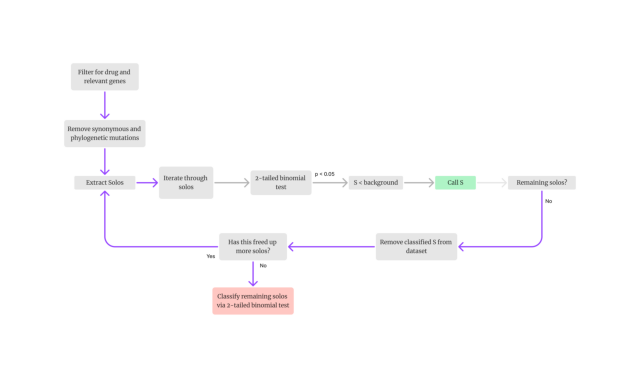

In [82]:
img = mpimg.imread('./imgs/manuscript_2/bdq_workflow.png')
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

We can build our catalogue on our entire dataset. 

We seed the catalogue with 2 neutral phylogenetic mutations in mmpL5; I948V and T794I [2]. These are extremeley high prevelance mutations and add noise, which makes classifications difficult as the method relies on solos.

In [83]:
#build the catalogue on the entire dataset.
catalogue = BuildCatalogue(samples=samples, mutations=cat_mutations, FRS=0.1, tails='two', seed=['mmpL5@I948V', 'mmpL5@T794I'], test='Binomial', background=0.1, strict_unlock=True)
#build a piezo-format catalogue dataframe
catalogue_df = catalogue.build_piezo("NC_000962.3", f"BDQ-2024.07", "1.1", "BDQ", piezo_wildcards)
catalogue_df

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,{},"{""seeded"": ""True""}",{}
1,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,{},"{""seeded"": ""True""}",{}
2,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,mmpL5@D767N,S,{},"[{""proportion"": 0.005496281926931782, ""confide...",{}
3,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,mmpL5@F696L,S,{},"[{""proportion"": 0.0, ""confidence"": [3.27005367...",{}
4,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,mmpL5@Y300!,S,{},"[{""proportion"": 0.0, ""confidence"": [1.68740879...",{}
...,...,...,...,...,...,...,...,...,...,...,...
561,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
562,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
563,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
564,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


In [84]:
#filter out seeded and default rule rows for catalogue counts
catalogue_df = catalogue_df[~catalogue_df['EVIDENCE'].apply(lambda x: any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]

print ('Total classifications count:\n', catalogue_df.PREDICTION.value_counts())

Total classifications count:
 U    459
R     70
S      5
Name: PREDICTION, dtype: int64


We have catalogued 70 resistance associated variants.

Most of our classifications are U's (or unknown) - these are primarily variants that display no evidence of resistance and exist in too few samples for a confident susceptible classification. A low background rate upweights resistance, and thus more data is needed to label a mutation susceptible.

/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GENE"] = df["MUTATION"].apply(lambda x: x.split("@")[0])


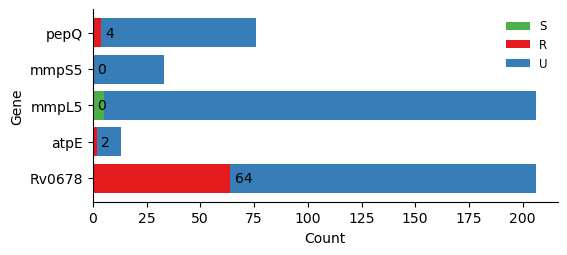

In [85]:
utils.plot_catalogue_counts(catalogue_df)


Of note, there are zero resistant classifications in either mmpS5 or mmpL5 - this is not surprising given the completely absent proportions of resistance for sample containing only mmpL5 or mmpS5 variants (`supplement.ipynb`).

This is mirrored in ...cite!!!
This does raise the question of whether these genes should be tier 1 candidates (as the WHO have defined)? 

Becuase our algorithm relies on solos to make classifications, genes that are not resistance associated add noise. We should be able to remove mmpL5 and mmpS5 and build an equally, if not more, comprehensive catalogue:

In [86]:
#remove mmpL5 and mmpS5 from dataset.
cat_mutations = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]
all = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])], how='left', on='UNIQUEID')
all.FRS.fillna(1, inplace=True)

#read in wildcards without mmpL5 and mmpS5
#read in wildcards for piezo catalogues
with open('./wildcards/bdq_wildcards_no_mmpL5.json') as f:
    piezo_wildcards = json.load(f)

In [87]:
#build the catalogue on the dataset without mmpL5 and mmpS5
catalogue = BuildCatalogue(samples=samples, mutations=cat_mutations, FRS=0.1, tails='two', test='Binomial', background=0.1, strict_unlock=True)
#build a piezo-format catalogue dataframe
catalogue_df = catalogue.build_piezo("NC_000962.3", f"BDQ-2024.07", "1.1", "BDQ", piezo_wildcards)
catalogue_df

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
313,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,Rv0678@*=,S,{},"{""default_rule"": ""True""}",{}
319,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,pepQ@*=,S,{},"{""default_rule"": ""True""}",{}
325,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@*=,S,{},"{""default_rule"": ""True""}",{}
5,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,Rv0678@192_ins_g,R,{},"[{""proportion"": 0.4230769230769231, ""confidenc...",{}
12,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,Rv0678@I67L,R,{},"[{""proportion"": 1.0, ""confidence"": [0.34238022...",{}
...,...,...,...,...,...,...,...,...,...,...,...
326,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
327,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
328,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
329,NC_000962.3,BDQ-2024.07,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


In [88]:
#filter out seeded and default rule rows for catalogue counts
catalogue_df = catalogue_df[~catalogue_df['EVIDENCE'].apply(lambda x: any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]

print ('Total classifications count:\n', catalogue_df.PREDICTION.value_counts())

Total classifications count:
 U    242
R     71
S      0
Name: PREDICTION, dtype: int64


We have no catalogued no susceptible variants (as these were in mmpL5), and have catalogued an additional Rv0678 mutation - no real change, as mmpL5 and mmpS5 variants were neutral anyway:

/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GENE"] = df["MUTATION"].apply(lambda x: x.split("@")[0])


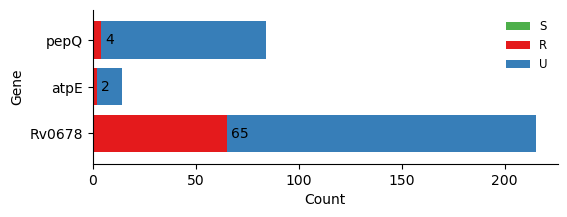

In [89]:
utils.plot_catalogue_counts(catalogue_df, figsize=(6, 2))

From a user-standpoint, depending on the application a catalogue with no susceptible rows may be unhelpful. A 10% background rate, although sensible, is perhaps too conservative considering the limited statistical power at each position. In its current form the catalogue presents a list of resistance associated variants only.

However, the beauty of an algorithmic, user-friendly tool is that the background can simply be shifted and the catalogues rebuilt in 1 line of code. Raising it will allow susceptible variants to be captured.

Let's examine which positions in Rv0678 were catalogued resistant relative to all mutated positions:

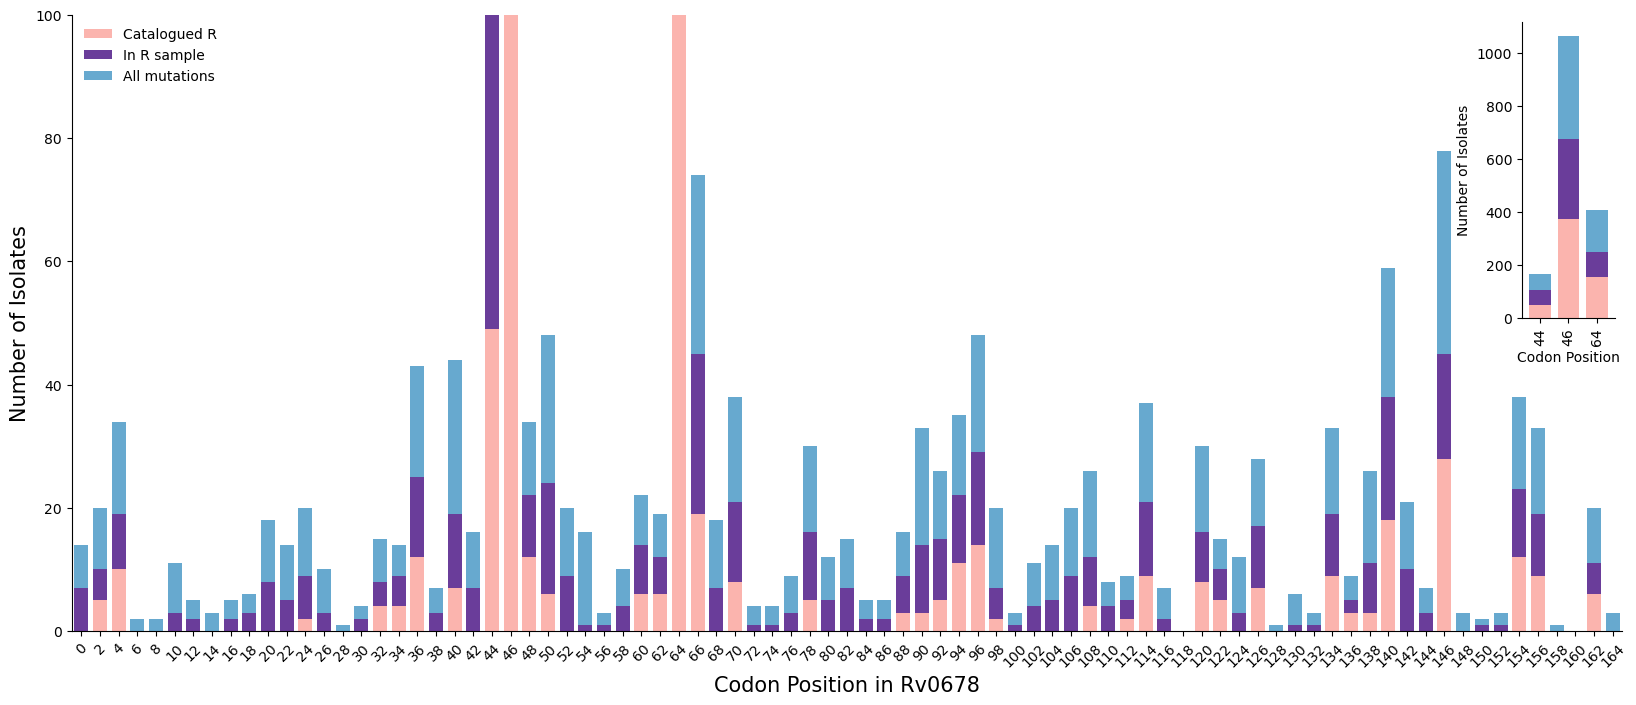

In [90]:
# Filter and update GENE_POSITION for Rv0678 gene
rv0678 = all[all.GENE == "Rv0678"].copy()

# Update GENE_POSITION based on NUCLEOTIDE_NUMBER
rv0678["GENE_POSITION"] = rv0678.apply(
    lambda row: row["GENE_POSITION"] / 3 if pd.notna(row["NUCLEOTIDE_NUMBER"]) else row["GENE_POSITION"],
    axis=1
)

# Ensure GENE_POSITION is numeric and valid
rv0678["GENE_POSITION"] = pd.to_numeric(rv0678["GENE_POSITION"], errors="coerce")
rv0678 = rv0678[rv0678["GENE_POSITION"] >= 0]

# Group positions by pairs (0, 2, 4, etc.)
rv0678["GROUPED_POSITION"] = (rv0678["GENE_POSITION"] // 2) * 2

# Create a complete range of grouped codon positions
all_grouped_positions = range(int(rv0678["GROUPED_POSITION"].min()), int(rv0678["GROUPED_POSITION"].max()) + 1, 2)
mutation_counts_grouped = rv0678["GROUPED_POSITION"].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

# Add IS_R column
rv0678['IS_R'] = [True if pheno == 'R' else False for pheno in rv0678.PHENOTYPE]

# Calculate R counts
r_counts_grouped = (
    rv0678[rv0678["IS_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

rv0678['CATALOGUED_R'] = [True if mut in catalogue_df[catalogue_df.PREDICTION=='R'].MUTATION.tolist() else False for mut in rv0678.MUTATION]

# Calculate catalogued R counts
catalogued_r_grouped = (
    rv0678[rv0678["CATALOGUED_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

grouped_counts = {'In R sample':r_counts_grouped, 'Catalogued R': catalogued_r_grouped, 'All mutations':mutation_counts_grouped}

utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=['#fbb4ae','#6a3d9a',  "#67a9cf"], high_count_threshold=100, figsize=(20, 8), bar_width=0.75)

Note, this plot is not a meausure of performance - all mutations in the dataset have been plotted (not solos), and hidden causal relationships exist - so actual resistance will be higher than what our catalogue predicts when only looking at that partiuclar position (ie not like for like). 

We can also look at which positions have been catalogued relative to solos to get a clearer picture of coverage. 

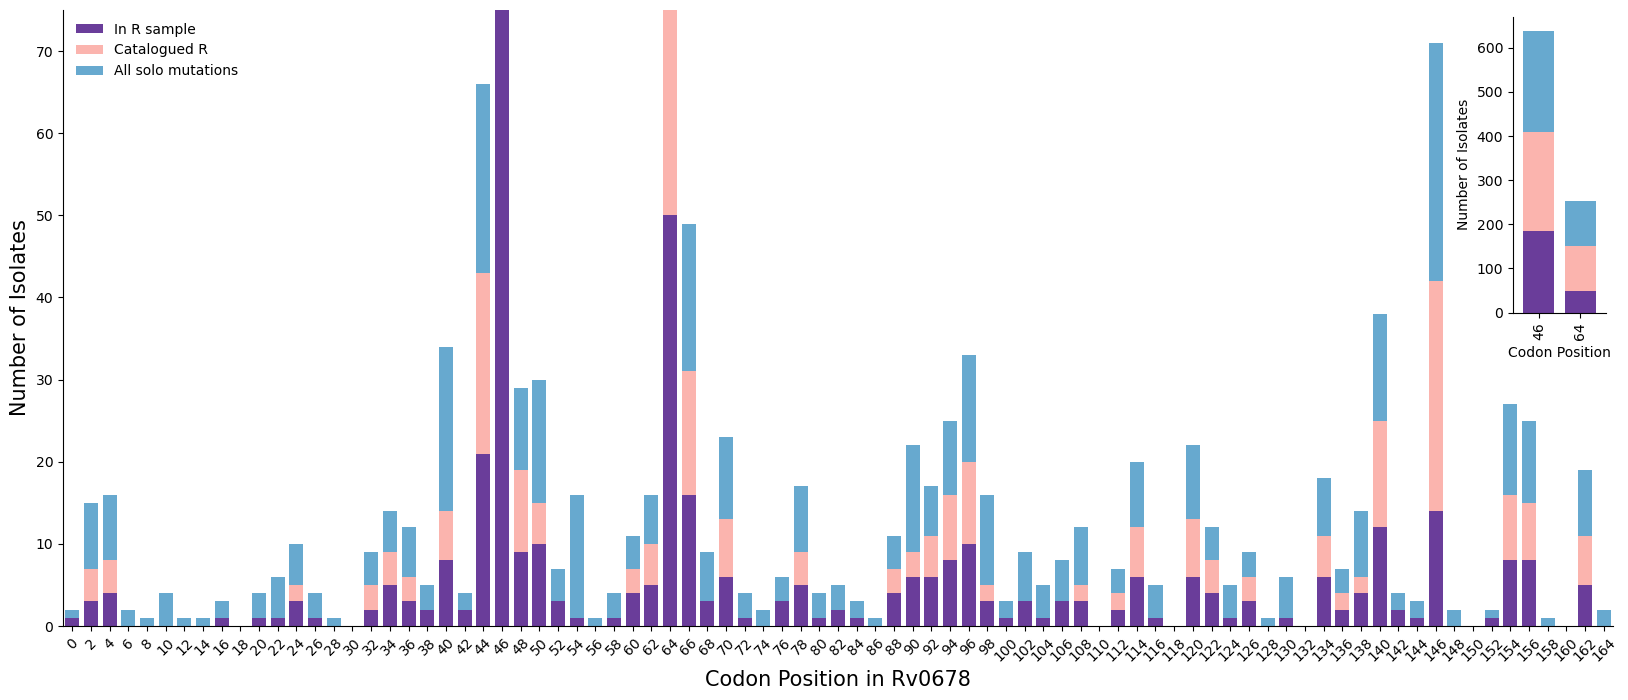

In [91]:
solos = all.groupby('UNIQUEID').filter(lambda x: len(x) == 1).UNIQUEID.tolist()

rv0678_solos = rv0678[rv0678.UNIQUEID.isin(solos)]

mutation_counts_grouped = rv0678_solos["GROUPED_POSITION"].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

# Calculate R counts
r_counts_grouped = (
    rv0678_solos[rv0678_solos["IS_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

catalogued_r_grouped = (
    rv0678_solos[rv0678_solos["CATALOGUED_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

grouped_counts = {'In R sample':r_counts_grouped, 'Catalogued R': catalogued_r_grouped, 'All solo mutations':mutation_counts_grouped}

utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=['#6a3d9a', '#fbb4ae',  "#67a9cf"], high_count_threshold=75, figsize=(20, 8), bar_width=0.75)

We have catalogued most high frequency positions associated with resistance, with only a few low-frequency resistance associated sites not catalogued (position has a purple bar, but no pink bar). Our false negative rate (exlcuding error) should therefore be low.

Without making sample predictions, we can already see our catalogue will overpredict resitance - pink bars higher than purple indicate false postives. This ultimately derives from the high levels of heteroresistance observed for frequent loss of function mutations, which itself is a function of the phenotype disagreements explored in `supplement.ipynb`. In fact, there will be a lot of major errors, however the major error rate should be low on account of the large number of susceptible samples we are using.

(obviously this plot has been coarse grained, so interpret with care)

Resistant variants are spread down the length of the gene (explored in `supplement.ipynb`).

Despite this high positional variance, a few mutations dominate; insertions at genomic positions 192, 141, and 138. These all exist within the DNA binding site of Rv0678 (citation needed - look at oren's lof paper):


In [92]:
counts_df = catalogue_df.copy()

# Convert 'EVIDENCE' column from string to list
counts_df['EVIDENCE'] = counts_df['EVIDENCE'].apply(ast.literal_eval)

# Extract R, S, and total counts
counts_df['R'] = counts_df['EVIDENCE'].apply(lambda x: x[0]['contingency'][0][0] if x else 0)
counts_df['S'] = counts_df['EVIDENCE'].apply(lambda x: x[0]['contingency'][0][1] if x else 0)
counts_df['total_count'] = counts_df['R'] + counts_df['S']

# Filter rows with total counts above 5

print ('The number of solos in resistant and susceptible samples used to classify each mutation in the catalogue (n > 5):')

counts_df[counts_df.total_count>5][['MUTATION', 'R', 'S', 'total_count']]

The number of solos in resistant and susceptible samples used to classify each mutation in the catalogue (n > 5):


,MUTATION,R,S,total_count
5,Rv0678@192_ins_g,33,45,78
45,Rv0678@141_ins_c,124,26,150
48,Rv0678@132_ins_gt,12,2,14
53,Rv0678@138_ins_g,35,12,47
60,Rv0678@491_ins_cg,5,1,6
76,Rv0678@G121R,6,1,7
107,Rv0678@C46R,5,1,6
175,Rv0678@M146T,11,14,25
178,Rv0678@193_del_g,10,6,16
190,Rv0678@I67S,11,0,11


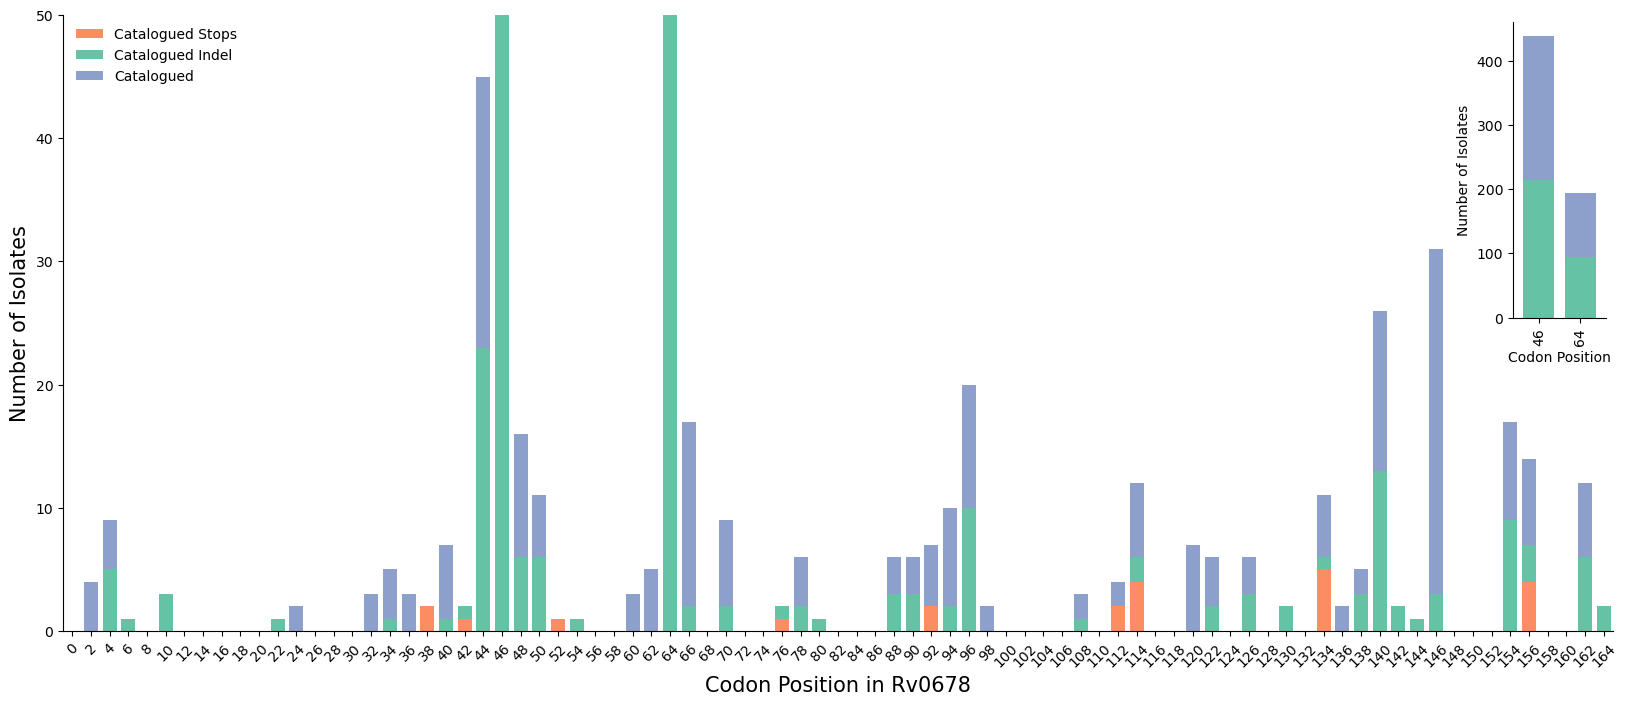

In [93]:
rv0678_solos = rv0678_solos.copy(deep=True)
# Add IS_STOP column
rv0678_solos['IS_STOP'] = rv0678_solos['MUTATION'].str.endswith('!')

# Add IS_INDEL column
rv0678_solos["IS_INDEL"] = rv0678_solos["INDEL_LENGTH"].notna()

# Calculate INDEL counts
indel_counts_grouped = (
    rv0678_solos[rv0678_solos["IS_INDEL"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Calculate STOP counts
stop_counts_grouped = (
    rv0678_solos[rv0678_solos["IS_STOP"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

grouped_counts = {'Catalogued': catalogued_r_grouped, 'Catalogued Stops':stop_counts_grouped, 'Catalogued Indel':indel_counts_grouped,}

utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=['#fc8d62',  '#66c2a5', "#8da0cb"], high_count_threshold=50, figsize=(20, 8), bar_width=0.75)


A huge proportion of catalogued mutations are indels, spread across the gene.

This does raise the question of whether an aggregate rule should be applied, such as in the WHOv2 catalogue, where pepQ and Rv0678 indels and premature stop codons are treated as single, resistant entries in the catalogue.

If we had sufficient phenotype homogeneity and a strong mean penetration, we could probably do the same.

This would probably bring our very major errors down, but at the cost of additional false positives (due to heteroresistance). Looking at the proportions of resistance in samples that (only) contain loss of function mutations.

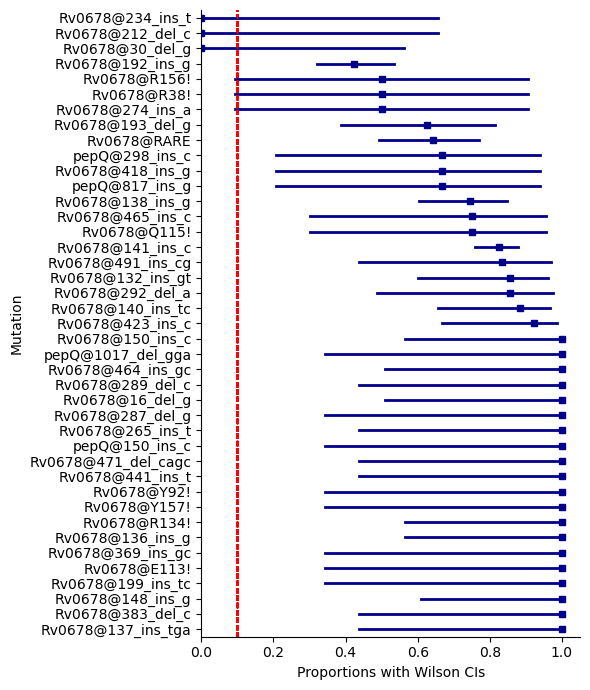

In [94]:
counts_df['IS_STOP'] = counts_df['MUTATION'].str.endswith('!')
counts_df["IS_INDEL"] = counts_df["MUTATION"].str.contains(r'ins_|del_')

lof_counts = counts_df[counts_df.IS_STOP | counts_df.IS_INDEL]

# Pool rows with total_count < 4
to_pool_df = lof_counts[lof_counts['total_count'] < 2]
remaining_df = lof_counts[lof_counts['total_count'] >= 2]

# Aggregate the pooled rows
pooled_row = to_pool_df.agg({
    'R': 'sum',
    'S': 'sum',
    'total_count': 'sum'
}).to_frame().T

# Set the MUTATION value for the pooled row
pooled_row.loc[:, 'MUTATION'] = 'Rv0678@RARE'

# Concatenate the remaining rows with the pooled row
high_freq = pd.concat([remaining_df, pooled_row], ignore_index=True)

#re-calculate proportion and confidence interval for each row (could just pull from evidence, but the rare row will screw it up)
high_freq[['Proportion', 'lower_bound', 'upper_bound']] = high_freq.apply(lambda row: utils.wilson(row['R'], row['S']), axis=1)

high_freq = high_freq.sort_values(by=['Proportion'], ascending=False)

utils.plot_catalogue_counts_from_df(high_freq, figsize=(6, 7), order=False, background=0.1)

Most high frequency loss of function mutations have high positive effect sizes - despite heroresistance, the probability of resistance for each mutation is sufficiently high to justify aggregating all loss of function mutations under an expert rule.

However, given that a fair number of low frequency mutations are still susceptible (even if statsitical power is low), and the fact we are yet to conclusively map out ressitance associated variants (even breakpoints are being called into question), remaining on the safe side and avoiding applying expert rules is probably more sensible.

However, `catomatic` does allow for the addition of expert rules, supporting single mutation additions or ammendmants as well as aggregate rules. However, we strongly advocate for entirely algorithmic approaches to ensure reproducibility, and would typically not advise adding or adapting rows.

# Catalogue Performance

To test the performance of our catalogue, we can use Piezo to make sample-level predictions, using a supplied catalogue as input.

Ideally, we would validate on an indendent test dataset. However, we don't have enough data to form another set, so like the WHOv2 we must make predictions on the trianing set, and just achknowledge this is probably an over estimate.

If we follow the WHO prediction protocol, whereby samples that contain catalogued Resistant mutations (Group 1 and 2) are resistant and all other samples are susceptible, and exlcuding mmpL5 and mmpS5, we achieve a maximum sensitivity of:

[[  607   259]
 [  172 10829]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7009237875288684
Specificity: 0.9843650577220253


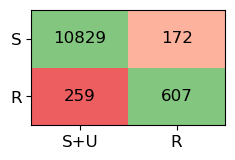

In [95]:
#export catalogue to piezo compatible csv
catalogue.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.07", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript_2/catalogue_FRS_01.csv')

#test catalogue on entire dataset using piezo
cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript_2/catalogue_FRS_01.csv", "BDQ", Print=True, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True)

Performance is decent, relative to the WHO catalogues.

However, we argue assuming samples that contain unkown or unclassified mutations are susceptible, is clinically dangerous - there is no evidence this is the case.

Therefore, we will use a tertiary prediction system (similar to the tertiary classification system), whereby samples that contain an unseen or unclassified mutation are reported seperately as 'unkown' or 'unclassified'.

We can then introduce an additional performance metric, 'sample coverage', which represents the fraction of samples for which R or S predictions could be made:

[[  607   135   124]
 [  172 10370   459]]
Catalogue coverage of isolates: 0.9508721665121767
Sensitivity: 0.8180592991913747
Specificity: 0.9836843103775375


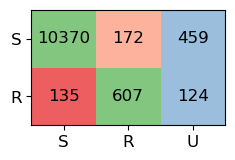

In [96]:
#test catalogue on entire dataset using piezo
cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript_2/catalogue_FRS_01.csv", "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(df_cm, U_to_S=False)

We accordingly achieve 81.8% sensitivity and 98.4% specificiy for for 95.1% of samples.

Our very major error has reduced from 29.9% to 18.2% as those samples containg low confidence susceptible variants are excluded.

The 172 false positives primarily derive from samples containing heteroresistant, high-frequency insertions or deletions (discussed above and in the `supplement.ipynb`):

In [97]:
print ('The number of False Positive predictions that contain each of the mutations found in all False positives:')
pd.DataFrame(all[all.UNIQUEID.isin(_FP_ids)].MUTATION.value_counts()).rename(columns={'MUTATION':'Samples'})

The number of False Positive predictions that contain each of the mutations found in all False positives:


,Samples
Rv0678@192_ins_g,55
Rv0678@141_ins_c,47
Rv0678@138_ins_g,26
Rv0678@M146T,14
Rv0678@c-11a,10
...,...
pepQ@A152A,1
pepQ@A153A,1
pepQ@T155G,1
pepQ@L157L,1


However, the 135 false negative predictions are more interesting:

In [98]:
print ('The number of False Negative predictions that contain each of the mutations found in all false negative:')
pd.DataFrame(all[all.UNIQUEID.isin(_FN_ids)].MUTATION.value_counts()).rename(columns={'MUTATION':'Samples'})

The number of False Negative predictions that contain each of the mutations found in all false negative:


,Samples


All false negative predictions contain wild type candidate genes, aside from 4 samples that each contain a non-phylogenetic and non-synonymous mutations in mmpL5.


In [99]:
print ('The number of False negative predictions the following mmpL5 mutations are found in:')

mutations[(~mutations.IS_NULL)&(mutations.UNIQUEID.isin(_FN_ids))].MUTATION.value_counts()

The number of False negative predictions the following mmpL5 mutations are found in:


mmpL5@I948V    129
mmpL5@T794I     78
mmpL5@D767N     16
mmpL5@L963L      3
mmpL5@P355P      3
mmpS5@N68N       1
mmpL5@A736D      1
mmpL5@A755T      1
mmpL5@G724G      1
mmpL5@G753G      1
mmpL5@L751L      1
mmpL5@L758L      1
mmpL5@S721N      1
mmpL5@S754S      1
mmpL5@T749T      1
mmpL5@L709I      1
Name: MUTATION, dtype: int64

In [100]:
print ('The number of which are not synonymous or phylogenetic:')
mutations[(~mutations.IS_NULL)&(~mutations.IS_SYNONYMOUS)&(~mutations.MUTATION.isin(['mmpL5@I948V', 'mmpL5@D767N', 'mmpL5@T794I']))&(mutations.UNIQUEID.isin(_FN_ids))].MUTATION.value_counts()

The number of which are not synonymous or phylogenetic:


mmpL5@A736D    1
mmpL5@A755T    1
mmpL5@S721N    1
mmpL5@L709I    1
Name: MUTATION, dtype: int64

These 4 samples' labels are very likely phenotyping or labelling error (ie false positive samples wrt to clinical phenotyping)- their sample numbers are too low be confident otherwise

All other false negative predictions(that contain phylogenetic or synonymous variants) are almost certainly error, unless a resistance mechanism is missing and yet to be reported.

In [101]:
print ('The number of false negative samples from each database')
phenotypes[phenotypes.UNIQUEID.isin(_FN_ids)].SOURCE.value_counts()

The number of false negative samples from each database


NICD        109
CRyPTIC      20
CRyPTIC2      6
Name: SOURCE, dtype: int64

The majority of false negative predictions, which we can be confident are as a result of false positive phenotypes, are NICD samples and contribute towards that dataset's inherent error rate.

However, this is therefore rather encouraging - it would appear our method has captured all resistance associated variants in the dataset.

# References

1. Timothy M. Walker, et al. Whole-genome sequencing for prediction of mycobacterium tuberculosis drug susceptibility and resistance: A retrospective cohort study. The Lancet Infectious Diseases, 15:1193–1202, 10 2015
2.  Matthias Merker, et al. Phylogenetically informative mutations in genes implicated in antibiotic resistance in Mycobacterium tuberculosis complex. Genome Medicine. 10.1186/s13073-020-00726-5
3. World Health Organisation. Catalogue of mutations in mycobacterium tuberculosis complex and their
association with drug resistance, 2021
4. World Health Organization. Catalogue of mutations in Mycobacterium tuberculosis complex and their
association with drug resistance. Second edition, 2023
5. https://github.com/fowler-lab/catomatic
6. DOI: 10.1128/AAC.01164-21
